In [1]:
"""
Created on Sun Mar 17 19:18:52 2019

@author: kurtb

Peterson, J. C., Abbott, J. T., & Griffiths, T. L. (2016). Adapting Deep
Network Features to Capture Psychological Representations. ArXiv:1608.02164.
Retrieved from http://arxiv.org/abs/1608.02164


Peterson, J. C., Abbott, J. T., & Griffiths, T. L. (2017). Evaluating
(and improving) the correspondence between deep neural networks and human
representations. ArXiv:1706.02417 [Cs]. Retrieved from
http://arxiv.org/abs/1706.02417
"""
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy
import scipy.misc
from torchvision.models import resnet18
import torchvision.transforms as transforms
from torch.autograd import Variable
from tqdm import tqdm
from PIL import Image
import itertools as it
%matplotlib inline


In [2]:
# %% image/data settings
nCategories = 10
firstView = 2
nOrientations = 20

imNumbs = np.array([9, 95, 79, 91, 98, 97, 52, 81,  7, 71])
mreF = '/home/kurtb/Dropbox/code/multiple_relation_embed'
imF = mreF + '/coil-100'
resf = mreF + '/res'
imTemplateP = mreF + '/coil-100/obj98__50.png'
imTemplate = scipy.misc.imread(imTemplateP)[:, :, 0]


/home/kurtb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


0it [00:00, ?it/s]/home/kurtb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
10it [00:02,  3.95it/s]


F_Pixel.shape (stimuli*pixels) = (200, 16384)


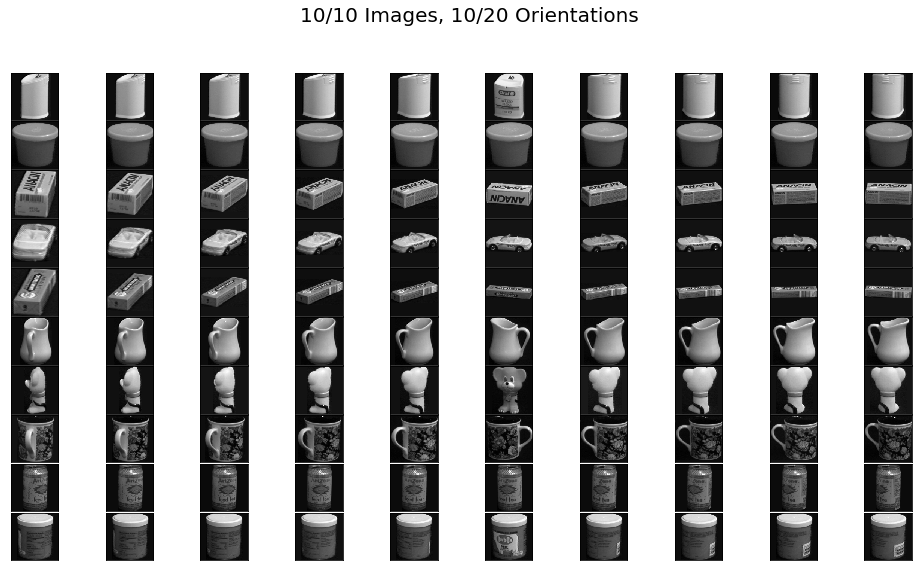

In [3]:
# %% Flatten images to form nImages*nPixels matrix, F_Pixel

def plot_similarity_matrix(S, nplot, title):
#     plt.figure()
    if nplot != 0:
        plt.subplot(2, 3, nplot)
    plt.imshow(S)
    plt.ylabel('nCategories * nOrientations')
    plt.xlabel('nCategories * nOrientations')
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()



# setup figure:
fig = plt.figure(figsize=(17, 9))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=-.0, hspace=-.0)
plt.tight_layout()
plt.suptitle('%d/%d Images, %d/%d Orientations' %
             (nCategories, nCategories, nOrientations/2,
              nOrientations), fontsize=20)

# iterate through images: create subplot, and flatten to row in F_Pixel
i = -1
F_Pixel = np.zeros((nOrientations * len(imNumbs), len(imTemplate.flatten())))
for iimg, img in tqdm(enumerate(imNumbs)):
    ps = np.sort(glob.glob(imF + '/obj%d_*.png' % img))
    ps = ps[firstView:nOrientations+firstView]
    for ip, p in enumerate(ps):
        i += 1
        im = scipy.misc.imread(p).mean(axis=2)
        if np.mod(i, 2) == 0:
            plt.subplot(nCategories, len(ps), i+1)
            plt.imshow(im, cmap='gray')
            frame1 = plt.gca()
            frame1.axes.get_xaxis().set_visible(False)
            frame1.axes.get_yaxis().set_visible(False)
#             plt.show()
        F_Pixel[i, :] = im.flatten()

print('F_Pixel.shape (stimuli*pixels) =', F_Pixel.shape)


/home/kurtb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


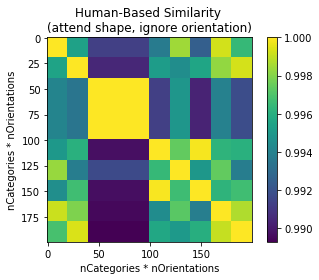

In [4]:
# %% imaginary human-based similarity matrix
cylinder_like = [10, 5, 0, 0, 0, 7, 7, 7, 9, 9]
cup_like = [1, 10, 0, 0, 0, 7, 0, 9, 5, 10]
rectangle_like = [0, 0, 10, 10, 10, 0, 0, 0, 0, 0]
handle_like = [0, 0, 0, 0, 0, 10, 5, 10, 0, 0]
mBase = np.vstack([cylinder_like,
                   cup_like,
                   rectangle_like,
                   handle_like])

m = np.zeros((10, 10))
S_human = np.zeros((nCategories*nOrientations, nCategories*nOrientations))

i, idx = 0, []
for ii in range(nCategories):
    idx.append(i)
    i += nOrientations
idx.append(200)
for i in range(10):
    for j in range(10):
        m[i, :] = np.sum([(mBase[k, i] - mBase[k, j])**2 for k in range(4)])
        S_human[idx[i]: idx[i+1], idx[j]: idx[j+1]] = m[i, j]
    m[i, :] = [1 - (m[i, h] / np.sum(m[i, :])) for h in range(10)]

for i in range(200):
    S_human[i, :] = [1 - (S_human[i, h] / np.sum(S_human[i, :])) for h in range(200)]

plot_similarity_matrix(S_human, 0,
                       'Human-Based Similarity \n(attend shape, ignore orientation)')

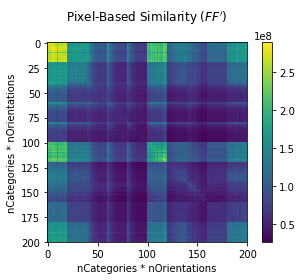

In [5]:
# %% This shape-level structure is not a direct function of pixel-space:
plot_similarity_matrix(F_Pixel.dot(F_Pixel.T), 0,
                       "Pixel-Based Similarity ($FF'$)\n")

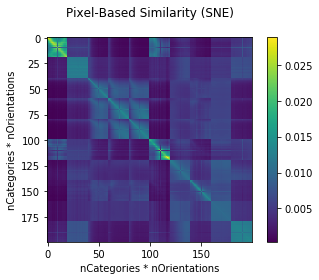

In [6]:
# %% functions to compute SNE-based pixelwise similarity:
def similarity(v1, v2, sigma=1):
    ''' when sigma=1, proportional to squared euclidean.
    when sigma=kernel_bandwidth < 1,
    '''
    return np.exp(- np.divide(1., sigma**2) * np.linalg.norm(v1 - v2)**2)


def similarity_matrix(F, sigma=1):
    '''F: N*ft matrix.
    sigma:neighborhood variance/ kernel bandwidth (SD of Gaussian kernel)

    when sigma < 1: The similarity of datapoint F[j, :] to datapoint F[i, :]
    is the conditional probability, p_j | i , that F[i, :] would pick F[j, :]
    as its neighbor if neighbors were picked in proportion to their probability
    density under a Gaussian centered at F[i, :].
    '''
    m = np.zeros((F.shape[0], F.shape[0]))
    for i in range(F.shape[0]):
        den = np.sum([similarity(F[i, :],
                                 F[k, :], sigma) for k in range(F.shape[0])])
        for j in range(F.shape[0]):
            num = similarity(F[i, :], F[j, :], sigma)
            m[i, j] = np.divide(num, den)
    return m


# % Pixel-based similarity matrix: S_SNE
S_SNE = similarity_matrix(F_Pixel, sigma=np.sqrt(5*10**7))

plot_similarity_matrix(S_SNE, 0, 'Pixel-Based Similarity (SNE)\n')

# S_SNE sums to 1 column-wise
assert(np.allclose(S_SNE.sum(axis=1), 1))

/home/kurtb/anaconda3/lib/python3.7/site-packages/torchvision/transforms/transforms.py:207: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
10it [00:11,  1.16s/it]


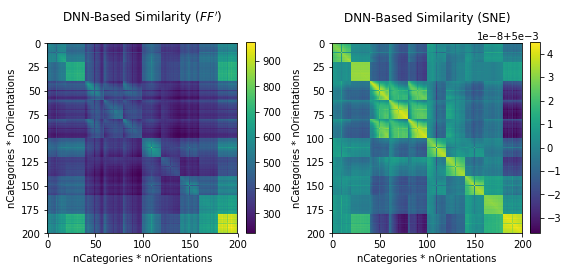

In [7]:
# %% resnet18 feature space:

outputs = []


def hook(module, input, output):
    outputs.append(output)


res18_model = resnet18(pretrained=True)
res18_model.eval()  # no grad
res18_model.layer4[0].conv2.register_forward_hook(hook)


def normalize_img(p):
    img = Image.open(p)
    scaler = transforms.Scale((128, 128))
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    to_tensor = transforms.ToTensor()
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    return t_img


def normalize_matrix(m):
    nFt = m.shape[1]
    for i in range(m.shape[0]):
        m[i, :] = [m[i, k] / np.sum(m[i, :]) for k in range(nFt)]
    return m


normed_img = normalize_img(imTemplateP)
out = res18_model(normed_img)
template_activation = outputs
F_DNN = np.zeros((nOrientations * len(imNumbs), len(outputs[0].flatten())))
for iimg, img in tqdm(enumerate(imNumbs)):
    ps = np.sort(glob.glob(imF + '/obj%d_*.png' % img))
    ps = ps[firstView:nOrientations+firstView]
    for ip, p in enumerate(ps):
        normed_img = normalize_img(p)
        out = res18_model(normed_img)

for i in np.arange(1, len(outputs)):
    F_DNN[i-1, :] = outputs[i].data.numpy().flatten()

# %
S_DNN_SNE = similarity_matrix(F_DNN, sigma=np.sqrt(5*10**7))

S_DNN_FF = F_DNN.dot(F_DNN.T)
nFt = len(S_DNN_FF[0, :])
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_similarity_matrix(S_DNN_FF, 0, "DNN-Based Similarity ($FF'$)\n")
plt.subplot(1,2,2)
plot_similarity_matrix(S_DNN_SNE, 0, 'DNN-Based Similarity (SNE)\n')


In [8]:
# %% learn linear transformaton, W,to make features more similar to human

def get_ridge_beta(X, Y, alpha):
    return np.linalg.inv((X.T.dot(X) + alpha
                          * np.eye(X.shape[1]))).dot(X.T).dot(Y)


def make_long(F, S):
    '''reorganize feature matrix, F, and similarity matrix, S, for ridge regression'''
    nFt = len(F[0, :])
    X = np.zeros((len(list(it.combinations(range(nCategories*nOrientations), 2))),
                  nFt))
    y = np.zeros((len(list(it.combinations(range(nCategories*nOrientations), 2))),
                  1))
    for idx, (i, j) in enumerate(it.combinations(range(nCategories*nOrientations),
                                 2)):
        X[idx, :] = F[i, :] * F[j, :]
        y[idx] = S[i, j]
    return X, y.flatten()


X, y = make_long(F_DNN, S_human)
print('X.shape', X.shape)
print('y.shape', y.shape)

# ridge regression -> FWF' 
alpha = .1
w = get_ridge_beta(X, y, alpha)
W = np.eye(F_DNN.shape[1]) * w
FWF = F_DNN.dot(W).dot(F_DNN.T)
FWF = normalize_matrix(FWF)

X.shape (19900, 8192)
y.shape (19900,)


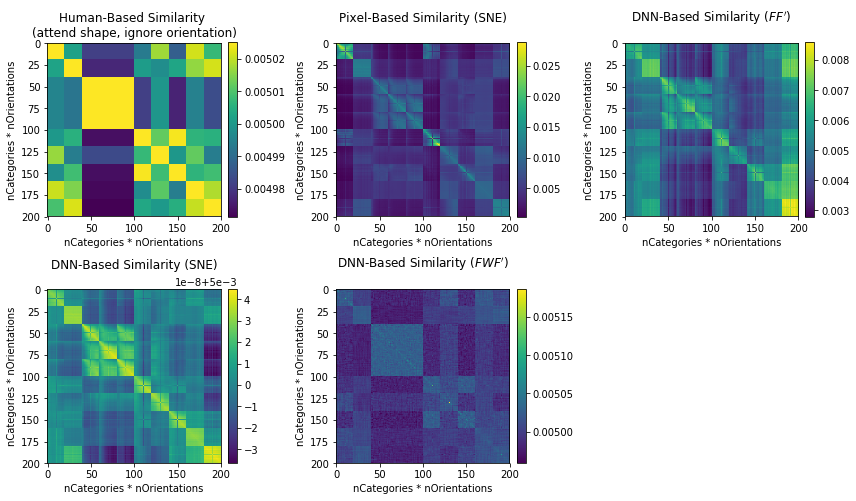

In [11]:
# plots
plt.figure(figsize=(12,7))
plt.subplot(2,3,1)
plot_similarity_matrix(S_human, 0,
                       'Human-Based Similarity \n(attend shape, ignore orientation)')

plt.subplot(2,3,2)
plot_similarity_matrix(S_SNE, 0, 'Pixel-Based Similarity (SNE)\n')

plt.subplot(2,3,3)
plot_similarity_matrix(S_DNN_FF, 0, "DNN-Based Similarity ($FF'$)\n")

plt.subplot(2,3,4)
plot_similarity_matrix(S_DNN_SNE, 0, "DNN-Based Similarity (SNE)\n")

plt.subplot(2,3,5)
plot_similarity_matrix(FWF, 0, "DNN-Based Similarity ($FWF'$)\n")

In [10]:
def KL(Pc, Qc):
    """ Epsilon added so no Qc is 0.

    from Q to P.. the amount of information lost when Q is used to approximate
    P"""
    epsilon = 0.00001

    vPc = Pc.flatten() + epsilon
    vQc = Qc.flatten() + epsilon
    return np.sum((vPc*np.log(vPc/vQc)))

print('S_SNE    \t',KL(normalize_matrix(S_human),normalize_matrix(S_SNE)).round(4))
print('S_DNN_FF\t',KL(normalize_matrix(S_human),normalize_matrix(S_DNN_FF)).round(4))
print('S_DNN_SNE \t',KL(normalize_matrix(S_human),normalize_matrix(S_DNN_SNE)).round(4))
print('FWF       \t',KL(normalize_matrix(S_human),normalize_matrix(FWF)).round(4))

S_SNE    	 38.894
S_DNN_FF	 4.1644
S_DNN_SNE 	 0.0013
FWF       	 0.0003
